In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta


In [ ]:
def get_stock_data(symbol, start="2015-01-01", end="2024-04-01"):
    if symbol in ["XYZ", "FAKE", "TEST"]:
        # Generate Fake Data (Dummy Stock)
        dates = pd.date_range(start=start, end=end, freq='B')  # Business days
        prices = np.linspace(100, 500, len(dates)) + np.random.normal(0, 10, len(dates))  # Trend + noise
        df = pd.DataFrame({"Close": prices}, index=dates)
    else:
        df = yf.download(symbol, start=start, end=end)
    
    if df.empty:
        raise ValueError(f"No data found for {symbol}. Try another symbol or date range.")
    
    df = df[['Close']]  # Keep only closing price
    df.dropna(inplace=True)  # Drop NaN values
    return df

# Choose stock (Real or Fake)
stock_symbol = input("Enter stock symbol (e.g., RELIANCE.NS, AAPL, XYZ): ").upper()
df = get_stock_data(stock_symbol)


In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Prepare training and testing data
sequence_length = 60
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - sequence_length:]

def create_sequences(data):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


In [5]:
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

16/16 [==============================] - 1s 12ms/step


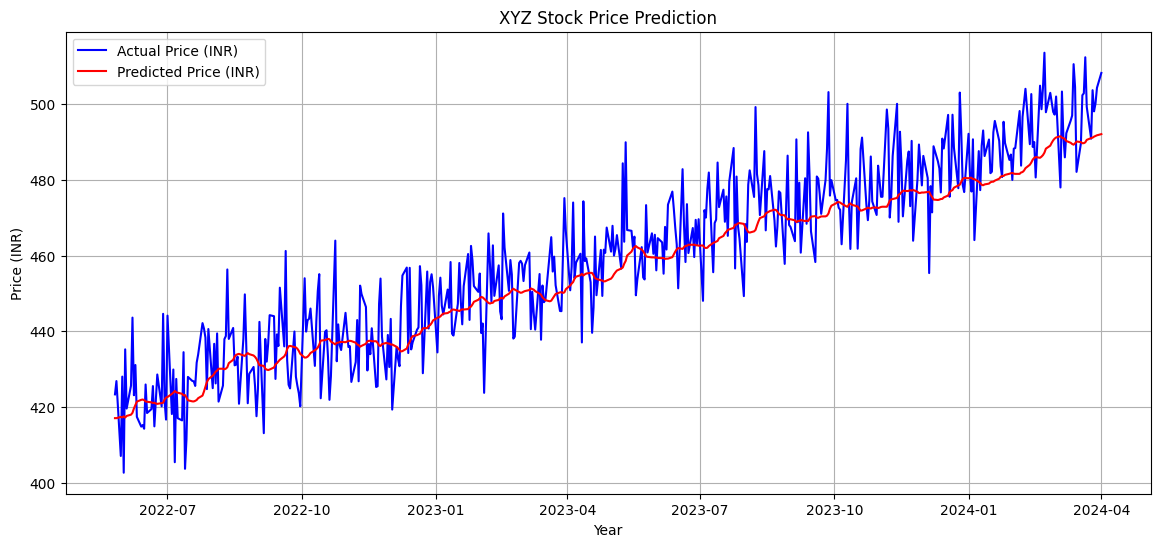

In [6]:
# Get dates for plotting
plot_dates = df.index[-len(predicted_price):]

plt.figure(figsize=(14,6))
plt.plot(plot_dates, y_test_actual, label='Actual Price (INR)', color='blue')
plt.plot(plot_dates, predicted_price, label='Predicted Price (INR)', color='red')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Year')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def predict_future_price(future_date):
    # Convert input date to datetime format
    future_date = datetime.strptime(future_date, "%Y-%m-%d")
    
    # Use the last 60 days of data as input for prediction
    last_60_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
    scaled_last_60_days = scaler.transform(last_60_days)
    input_seq = np.array([scaled_last_60_days])

    # Step-by-step prediction until the target date
    current_date = df.index[-1]
    
    while current_date < future_date:
        predicted_value_scaled = model.predict(input_seq)[0, 0]  # Predict next day
        input_seq = np.append(input_seq[:, 1:, :], [[[predicted_value_scaled]]], axis=1)  # Shift sequence
        current_date += timedelta(days=1)
    
    # Convert predicted price back to INR
    predicted_price_inr = scaler.inverse_transform([[predicted_value_scaled]])[0, 0]
    
    return round(predicted_price_inr, 2)

# Get user input for future date and predict
future_date = input("Enter future date (YYYY-MM-DD) for prediction: ")
predicted_value = predict_future_price(future_date)
print(f"Predicted stock price on {future_date}: ₹{predicted_value}")
